In [11]:
from os import environ
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= '8192'
environ['n_epochs']= '1500'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.3 '*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = '/data/scratch/mmerouani/data/speedup_dataset_research_batch1001-2500.pkl'

%run utils.ipynb

In [3]:
print("loading data")

# train_dl, val_dl, test_dl = train_dev_split(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log)
train_dl, val_dl, test_dl = train_dev_split_transform(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log,
                                                     transform_func=lambda Y : 1/Y,
                                                     filter_func=None)
db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

print("data loaded")
print(val_dl.dataset.X.shape)

loading data


100%|██████████| 458876/458876 [13:48<00:00, 553.55it/s] 


data loaded
(458876, 3592)


In [5]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]

model = None 

if batch_norm:
    model = Model_BN_ELU(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)

# model = nn.DataParallel(model)
# model.to(device)

if loss_func == 'MSE':
    criterion = mse_criterion
else:
    criterion = mape_criterion

l = fai.basic_train.Learner(db, model, loss_func=criterion, metrics=[mse_criterion],
                            callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                            monitor='mse_criterion', min_delta=0, patience=150)],silent=True)

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    
print(criterion)    

<function mse_criterion at 0x7fb3cb050158>


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


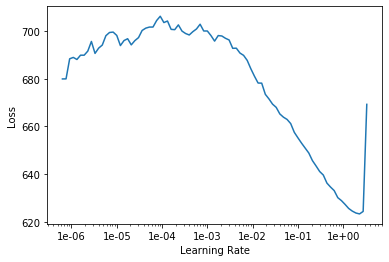

In [6]:
l.lr_find()
l.recorder.plot()

In [7]:
lr = 1e-03

In [8]:
l.fit_one_cycle(1500, lr)

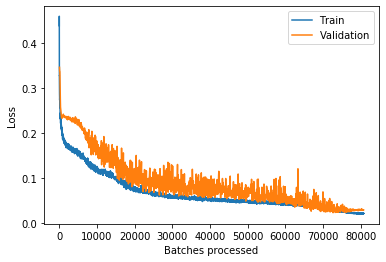

In [7]:
l.recorder.plot_losses()

In [29]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}_batch1001-2500_ELU_MSE_inverse")

In [21]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)
test_df=get_results_df(test_dl, l.model)

In [22]:
test_df.describe()

,index,prediction,target,speedup,abs_diff,APE,SMAPE,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,11.098552,10.903996,0.438427,3.075651,66.447647,85.732559,0.757900,0.940400,0.750000
std,2886.89568,23.467976,23.508726,0.384616,5.840970,85.896927,79.414223,0.428376,0.236756,0.433034
min,0.00000,0.000000,0.378068,0.004559,0.000561,0.040809,0.040818,0.000000,0.000000,0.000000
25%,2499.75000,0.000000,1.288857,0.086719,0.954347,17.093031,17.113403,1.000000,1.000000,0.750000
50%,4999.50000,3.474495,3.233476,0.309265,1.355621,47.712870,50.623348,1.000000,1.000000,1.000000
75%,7499.25000,12.104778,11.531492,0.775881,2.601631,100.000000,200.000000,1.000000,1.000000,1.000000
max,9999.00000,191.724838,219.370346,2.645030,64.777817,1059.229370,200.000015,1.000000,1.000000,1.000000


In [23]:
val_df.describe()

,index,prediction,target,speedup,abs_diff,APE,SMAPE,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,11.488132,11.780406,0.434748,2.922600,62.541176,86.289261,0.782900,0.947300,0.750000
std,2886.89568,25.617477,25.610207,0.526266,5.782752,75.401016,81.565407,0.412292,0.223445,0.433034
min,10000.00000,0.000000,0.145649,0.004063,0.000078,0.000571,0.000571,0.000000,0.000000,0.000000
25%,12499.75000,0.000000,1.463150,0.088260,0.948128,15.817019,15.958954,1.000000,1.000000,0.750000
50%,14999.50000,2.718983,3.093708,0.323237,1.397799,42.369080,43.798750,1.000000,1.000000,1.000000
75%,17499.25000,11.731441,11.330190,0.683457,2.539973,100.000000,200.000000,1.000000,1.000000,1.000000
max,19999.00000,220.992310,246.104568,6.865816,141.481262,840.645874,200.000015,1.000000,1.000000,1.000000


In [24]:
train_df.describe()

,index,prediction,target,speedup,abs_diff,APE,SMAPE,interchange,tile,unroll
count,438876.000000,438876.000000,438876.000000,438876.000000,438876.000000,438876.000000,438876.000000,438876.000000,438876.000000,438876.000000
mean,239437.500000,10.832894,11.355379,0.417869,1.869952,50.621685,81.134720,0.770386,0.943353,0.750000
std,126692.732707,24.059313,24.043819,0.450577,2.339988,47.508152,83.214241,0.420585,0.231167,0.433013
min,20000.000000,0.000000,0.037623,0.002826,0.000009,0.000106,0.000106,0.000000,0.000000,0.000000
25%,129718.750000,0.000000,1.414381,0.089580,0.794494,11.088913,11.078519,1.000000,1.000000,0.750000
50%,239437.500000,2.884928,3.154334,0.317024,1.226655,34.062506,35.285439,1.000000,1.000000,1.000000
75%,349156.250000,10.820855,11.163268,0.707023,2.011203,100.000000,200.000000,1.000000,1.000000,1.000000
max,458875.000000,347.571716,353.865967,26.579260,98.714508,1013.419067,200.000015,1.000000,1.000000,1.000000


In [55]:
print("Test set:")
print(f"MSE: {mean_squared_error(np.array(test_df['target']), np.array(test_df['prediction']))}")
print(f"R-square score: {r2_score(np.array(test_df['target']), np.array(test_df['prediction']))}")

Test set:
MSE: 43.57326889038086
R-square score: 0.9211494653942405


In [58]:
print("Validation set:")
print(f"MSE: {mean_squared_error(np.array(val_df['target']), np.array(val_df['prediction']))}")
print(f"R-square score: {r2_score(np.array(val_df['target']), np.array(val_df['prediction']))}")

Validation set:
MSE: 41.97845458984375
R-square score: 0.9359906839134117


In [59]:
print("Train set:")
print(f"MSE: {mean_squared_error(np.array(train_df['target']), np.array(train_df['prediction']))}")
print(f"R-square score: {r2_score(np.array(train_df['target']), np.array(train_df['prediction']))}")

Train set:
MSE: 8.973251342773438
R-square score: 0.984477366046974


In [43]:
df = val_df
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,32.000000,32.0,32.000000,32.000000
mean,1.595547,1.0,1.752714,175.271362
std,2.100466,0.0,1.267664,126.766365
min,0.000000,1.0,0.350441,35.044098
25%,0.000000,1.0,1.000000,100.000000
50%,0.000000,1.0,1.000000,100.000000
75%,3.766825,1.0,2.766825,276.682465
max,5.354717,1.0,4.354717,435.471680


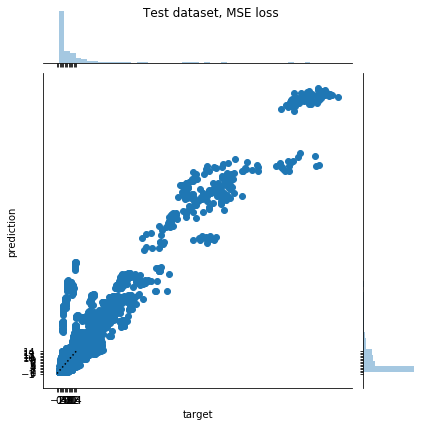

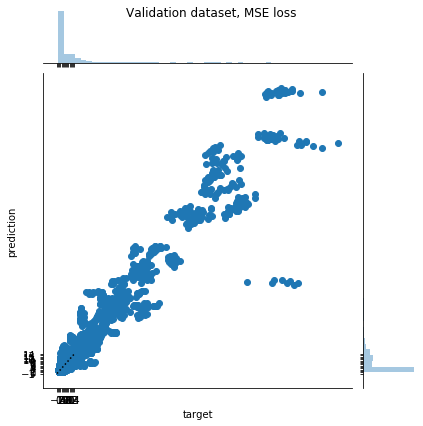

In [48]:
# df1 = val_df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
df1 = test_df

joint_plot(df1, f"Test dataset, {loss_func} loss")
df2 = val_df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [49]:
df_ = val_df.sort_values(by=["abs_diff"])

df_['x'] = range(len(df_))

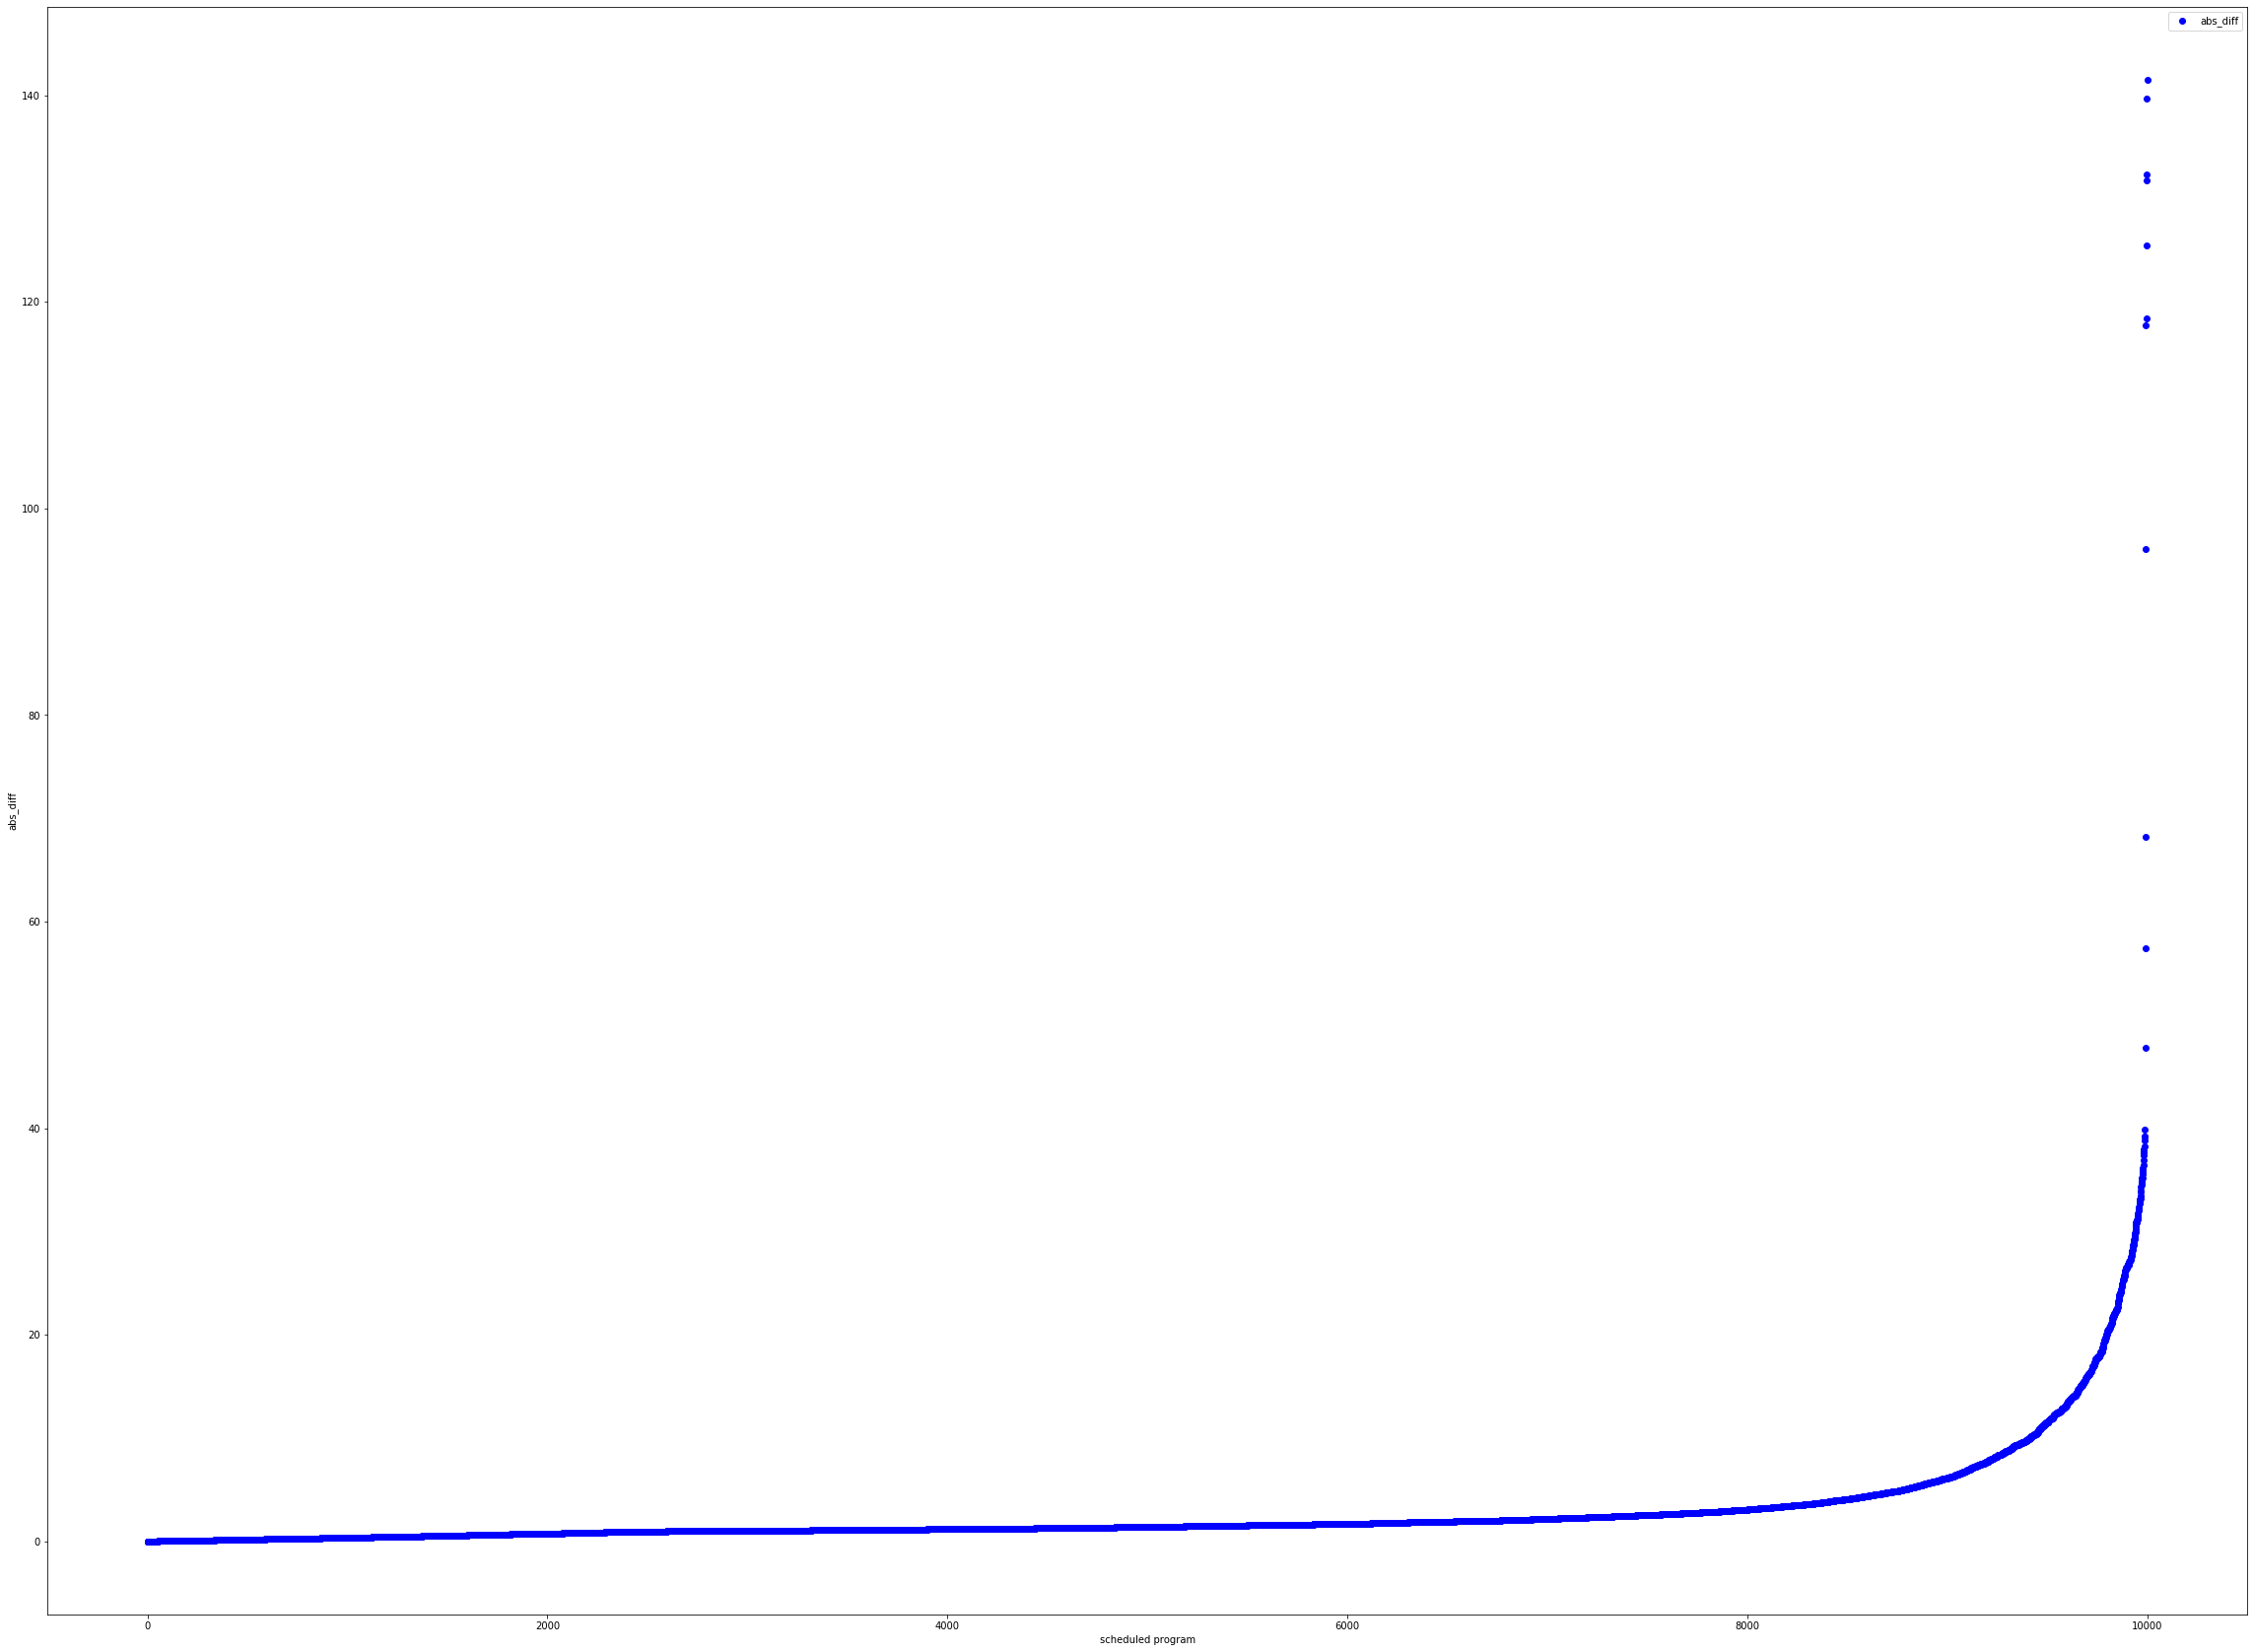

In [52]:
plt.plot('x', 'abs_diff', 'bo', data=df_)


plt.xlabel('scheduled program')
plt.ylabel('abs_diff')
plt.legend()

In [20]:
l=l.load("speedup_Adam_batch_norm_True_MSE_nlayers_4_log_False_batch1001-2500_ELU_MSE_inverse")